In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Lambda, Input, Dense, BatchNormalization
from keras import backend as K
from keras import objectives
import copy
%pylab inline

## Plotting Styles configuration
 
plt.style.use('seaborn-white')
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
exclusions = pd.read_csv('excluded_npi.data')

# Frauds in Different Specialities

SPECIALTY
NURSE/NURSES AIDE       31121
OWNER/OPERATOR           3356
HEALTH CARE AIDE         2849
CHIROPRACTIC             1988
GENERAL PRACTICE/FP      1987
NO KNOWN AFFILIATION     1907
EMPLOYEE                 1902
PHARMACIST               1496
DENTIST                  1340
PERSONAL CARE PROVID     1297
TECHNICIAN               1109
GENERAL PRACTICE         1057
DME - GENERAL             743
HOME HEALTH AGENCY        731
COUNSELOR                 644
INTERNAL MEDICINE         643
BUSINESS MANAGER          586
FAMILY PRACTICE           576
PSYCHOLOGY                557
PHARMACY TECHNICIAN       528
Name: SPECIALTY, dtype: int64


Text(0.5,0,'Speciality')

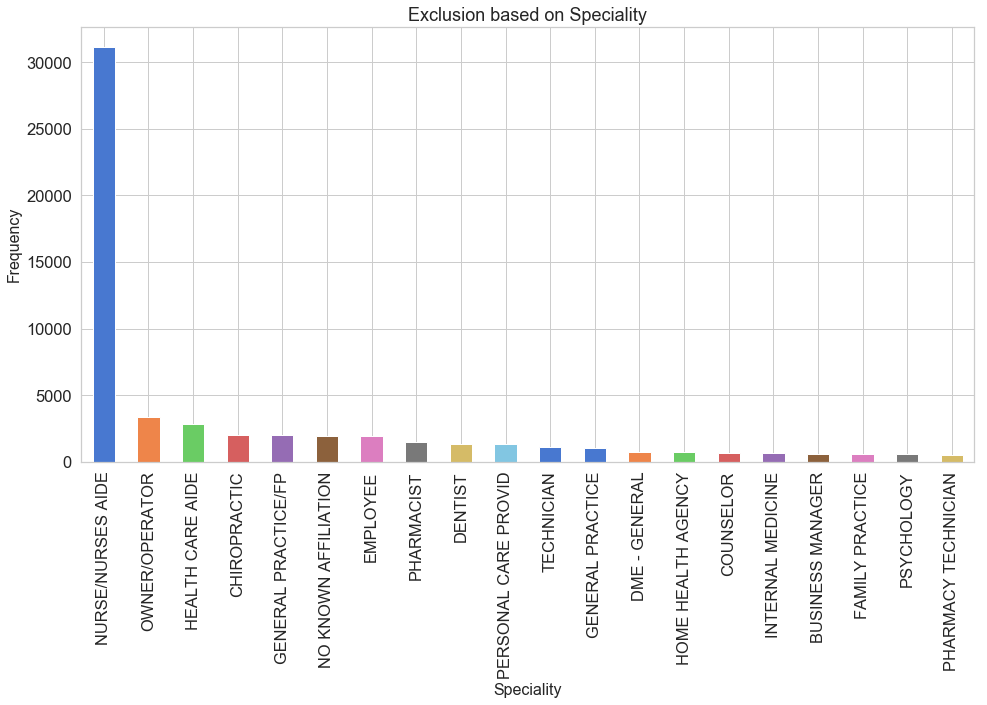

In [3]:
exclusion_types = exclusions.groupby("SPECIALTY")["SPECIALTY"].count().nlargest(20)
print(exclusion_types)
plt.figure(figsize=(16,8))
ax = exclusion_types.plot(kind='bar')
ax.set_title("Exclusion based on Speciality", fontsize=18)
ax.set_ylabel("Frequency",fontsize = 16)
ax.set_xlabel("Speciality", fontsize = 16)

In [4]:
exclusions["year"] = exclusions.EXCLDATE.apply(lambda x: int(str(x)[:4]))
exclusions15 = exclusions[exclusions["year"] > 2015]

# Frauds in Different Specialities since 2015

Text(0.5,0,'Speciality')

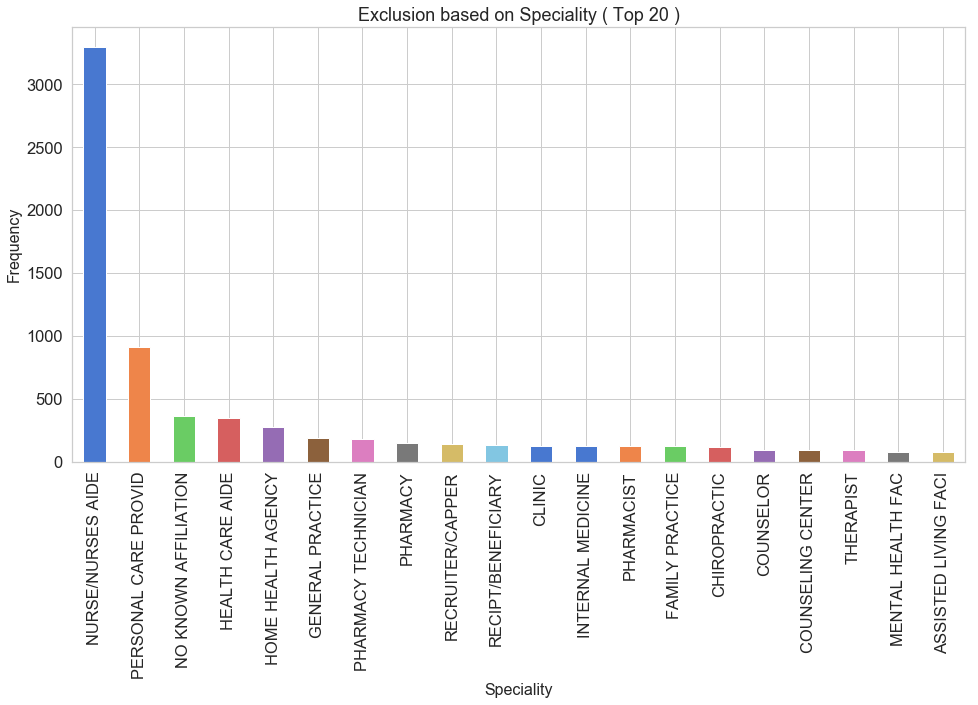

In [5]:
exclusion_types = exclusions15.groupby("SPECIALTY")["SPECIALTY"].count().nlargest(20)
#exclusion_types  = exclusion_types[exclusion_types>200]
plt.figure(figsize=(16,8))
ax = exclusion_types.plot(kind='bar')
ax.set_title("Exclusion based on Speciality ( Top 20 )", fontsize=18)
ax.set_ylabel("Frequency",fontsize = 16)
ax.set_xlabel("Speciality", fontsize = 16)

In [6]:
df = pd.read_csv('split1.data', delimiter="\t")
print(df.columns)
print(df.dtypes)
excluded = pd.read_csv('excluded_npi.data')
excluded["year"] = excluded.EXCLDATE.apply(lambda x: int(str(x)[:4]))
fraud_npi = excluded[(excluded.NPI != 0) & (excluded.year > 2015)].NPI.values
print("Number of fraudulent NPI's: " + str(len(fraud_npi)))

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')
npi                                int64
nppes_provider_last_org_name      object
nppes_provider_first_name         object
nppes_provider_city               object
nppes_provider_state              object
specialty_description             object
description_flag                  object
drug_name                         object
generic_name                      object
bene_count                       float64
total_claim_count                  int64

# Fraudulent Providers Detection
## Data Preprocessing

## We keep the following list of Columns and dervice the rest of the features
- npi
- nppes_provider_city
- nppes_provider_state
- specialty_description
- drug_name
- generic_name
- total_30_day_fill_count
- total_day_supply
- total_drug_cost

In [7]:
df_sample = df
cols_to_keep = ["npi","nppes_provider_city","nppes_provider_state","specialty_description","drug_name",\
               "generic_name","total_30_day_fill_count","total_day_supply","total_drug_cost"]
df_sample = df_sample[cols_to_keep]
df_sample.head()

,npi,nppes_provider_city,nppes_provider_state,specialty_description,drug_name,generic_name,total_30_day_fill_count,total_day_supply,total_drug_cost
0,1912175340,SAN JUAN BAUTISTA,CA,General Surgery,HYDROCODONE-ACETAMINOPHEN,HYDROCODONE/ACETAMINOPHEN,15.0,213,186.85
1,1912175340,SAN JUAN BAUTISTA,CA,General Surgery,IBUPROFEN,IBUPROFEN,21.0,305,114.18
2,1912175340,SAN JUAN BAUTISTA,CA,General Surgery,METOCLOPRAMIDE HCL,METOCLOPRAMIDE HCL,34.0,244,117.93
3,1417051921,CATOOSA,OK,Physician Assistant,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE,17.0,44,57.64
4,1417051921,CATOOSA,OK,Physician Assistant,AZITHROMYCIN,AZITHROMYCIN,44.0,219,305.91


### Features Extraction

In [8]:
df_agg = df_sample.groupby('npi').agg({'drug_name':'nunique','generic_name':'nunique','total_30_day_fill_count':['sum', np.max,'var'],
                                       'total_drug_cost':['sum', np.max,'var'],'total_day_supply':['sum', np.max,'var']})
df_agg.columns = ["_".join(x) for x in df_agg.columns.ravel()]
df_feat = df_agg
df_feat.fillna(0, inplace=True)
df_feat["is_fraud"] = 0
df_feat.loc[df_feat.index.isin(fraud_npi),"is_fraud"] = 1
df_feat.head()

,total_day_supply_sum,total_day_supply_amax,total_day_supply_var,generic_name_nunique,drug_name_nunique,total_30_day_fill_count_sum,total_30_day_fill_count_amax,total_30_day_fill_count_var,total_drug_cost_sum,total_drug_cost_amax,total_drug_cost_var,is_fraud
npi,,,,,,,,,,,,
1003000126,13159,2415,377349.747619,21,21,583.6,81.0,382.246905,16355.02,8723.13,3.816890e+06,0
1003000167,119,87,1512.500000,2,2,28.0,14.0,0.000000,111.64,70.85,4.518018e+02,0
1003000282,445,445,0.000000,1,1,15.0,15.0,0.000000,353.58,353.58,0.000000e+00,0
1003000407,18478,1926,107957.467227,35,35,942.4,80.0,302.490202,29906.34,7491.36,3.226513e+06,0
1003000720,2100,810,42300.000000,4,4,70.0,27.0,47.000000,479.23,221.99,4.894329e+03,0


### Derived Features Dataset

In [9]:
df_feat.head()

,total_day_supply_sum,total_day_supply_amax,total_day_supply_var,generic_name_nunique,drug_name_nunique,total_30_day_fill_count_sum,total_30_day_fill_count_amax,total_30_day_fill_count_var,total_drug_cost_sum,total_drug_cost_amax,total_drug_cost_var,is_fraud
npi,,,,,,,,,,,,
1003000126,13159,2415,377349.747619,21,21,583.6,81.0,382.246905,16355.02,8723.13,3.816890e+06,0
1003000167,119,87,1512.500000,2,2,28.0,14.0,0.000000,111.64,70.85,4.518018e+02,0
1003000282,445,445,0.000000,1,1,15.0,15.0,0.000000,353.58,353.58,0.000000e+00,0
1003000407,18478,1926,107957.467227,35,35,942.4,80.0,302.490202,29906.34,7491.36,3.226513e+06,0
1003000720,2100,810,42300.000000,4,4,70.0,27.0,47.000000,479.23,221.99,4.894329e+03,0


In [10]:
x = df_feat.ix[:,:-1].values 
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_feat_sampled_normalized = pd.DataFrame(x_scaled, columns=df_feat.columns[:-1])
df_feat_sampled_normalized["is_fraud"] = df_feat.ix[:,-1].values
df_feat_sampled_normalized.head()

,total_day_supply_sum,total_day_supply_amax,total_day_supply_var,generic_name_nunique,drug_name_nunique,total_30_day_fill_count_sum,total_30_day_fill_count_amax,total_30_day_fill_count_var,total_drug_cost_sum,total_drug_cost_amax,total_drug_cost_var,is_fraud
0,-0.353818,-0.337856,-0.110048,-0.135950,-0.164915,-0.330176,-0.363630,-0.052488,-0.307773,-0.148931,-0.017989,0
1,-0.452939,-0.565019,-0.118847,-0.603363,-0.592256,-0.448653,-0.551964,-0.055889,-0.354996,-0.201294,-0.018032,0
2,-0.450461,-0.530086,-0.118882,-0.627963,-0.614747,-0.451425,-0.549153,-0.055889,-0.354293,-0.199583,-0.018032,0
3,-0.313387,-0.385572,-0.116355,0.208459,0.149968,-0.253666,-0.366441,-0.053198,-0.268376,-0.156385,-0.017995,0
4,-0.437881,-0.494469,-0.117892,-0.554161,-0.547273,-0.439697,-0.515422,-0.055470,-0.353928,-0.200379,-0.018032,0


# 1 ) Using Variational Auto-Encoders

In [11]:
X_train, X_test = train_test_split(df_feat_sampled_normalized, test_size=0.2, random_state=RANDOM_SEED)
#X_train = X_train[X_train.is_fraud == 0]
X_train = X_train.drop(['is_fraud'], axis=1)
y_test = X_test['is_fraud']
X_test = X_test.drop(['is_fraud'], axis=1)
X_train = X_train.values
X_test = X_test.values

## Defining the NN Model & Training over the dataset

In [32]:

hidden_size = 6 #size of the hidden layer in encoder and decoder
latent_dim = 2 #number of latent variables to learn

input_dim = X_train.shape[1]

x = Input(shape=(input_dim,))
t = BatchNormalization()(x)
t = Dense(hidden_size, activation='tanh' , name='encoder_hidden')(t)
t = BatchNormalization()(t)

z_mean = Dense(latent_dim, name='z_mean')(t)
z_log_var = Dense(latent_dim, name='z_log_var')(t)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, name='z_sampled')([z_mean, z_log_var])
#t = BatchNormalization()(z)

t = Dense(hidden_size, activation='tanh', name='decoder_hidden')(z)
#t = BatchNormalization()(t)

decoded_mean = Dense(input_dim, activation=None, name='decoded_mean')(t)

vae = Model(x, decoded_mean)

def rec_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

def kl_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(x, decoded_mean):
    rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((rec_loss + kl_loss) / 2)

vae.compile(optimizer=Adam(lr=1e-2), loss=vae_loss, metrics=[rec_loss, kl_loss])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 11)           44          input_26[0][0]                   
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 6)            72          batch_normalization_3[0][0]      
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 6)            24          encoder_hidden[0][0]             
__________________________________________________________________________________________________
z_mean (De

In [36]:
n_epochs = 30
batch_size = 128

early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=1e-5) #stop training if loss does not decrease with at least 0.00001
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, min_delta=1e-5, factor=0.2) #reduce learning rate (divide it by 5 = multiply it by 0.2) if loss does not decrease with at least 0.00001

callbacks = [early_stopping, reduce_lr]

#collect training data in history object
history = vae.fit(X_train, X_train, 
                  validation_data=(X_test, X_test), 
                  batch_size=batch_size, epochs=n_epochs, 
                  callbacks=callbacks)

Train on 281326 samples, validate on 70332 samples
Epoch 1/30
281326/281326 [==============================] - 23s 80us/step - loss: 3.2366 - rec_loss: 5.4638 - kl_loss: 1.0094 - val_loss: 3.5735 - val_rec_loss: 6.0944 - val_kl_loss: 1.0525
Epoch 2/30
281326/281326 [==============================] - 20s 71us/step - loss: 2.8034 - rec_loss: 4.5007 - kl_loss: 1.1062 - val_loss: 3.4562 - val_rec_loss: 5.8784 - val_kl_loss: 1.0340
Epoch 3/30
281326/281326 [==============================] - 22s 77us/step - loss: 2.7191 - rec_loss: 4.3357 - kl_loss: 1.1024 - val_loss: 3.4311 - val_rec_loss: 5.8796 - val_kl_loss: 0.9826
Epoch 4/30
281326/281326 [==============================] - 28s 98us/step - loss: 2.6968 - rec_loss: 4.2970 - kl_loss: 1.0966 - val_loss: 3.3649 - val_rec_loss: 5.6891 - val_kl_loss: 1.0406
Epoch 5/30
281326/281326 [==============================] - 22s 77us/step - loss: 2.6907 - rec_loss: 4.2939 - kl_loss: 1.0876 - val_loss: 3.3146 - val_rec_loss: 5.5764 - val_kl_loss: 1.0527

## Plotting Loss

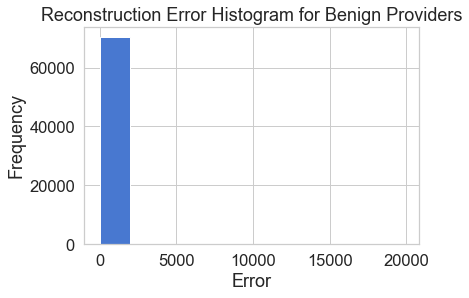

In [38]:
predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

threshold = error_df.reconstruction_error.nlargest(int(0.05*len(error_df))).values[-1]
error_df["pred"] = 0
error_df.loc[error_df.reconstruction_error >= threshold,"pred"] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]# & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
_ = ax.set_title("Reconstruction Error Histogram for Benign Providers")
_ = ax.set_xlabel("Error")
_ = ax.set_ylabel("Frequency")

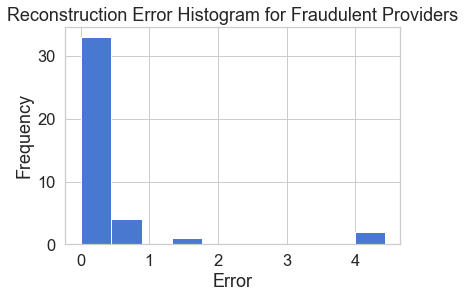

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
_ = ax.set_title("Reconstruction Error Histogram for Fraudulent Providers")
_ = ax.set_xlabel("Error")
_ = ax.set_ylabel("Frequency")

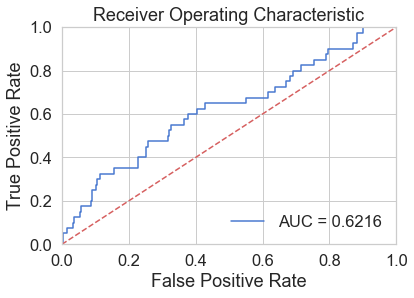

In [40]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

0.5790417677492278


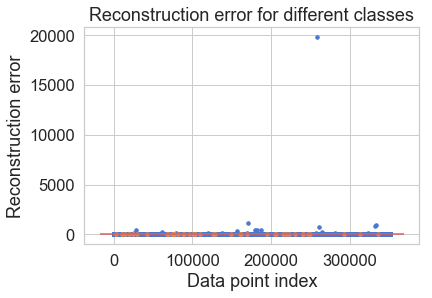

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
print(threshold)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


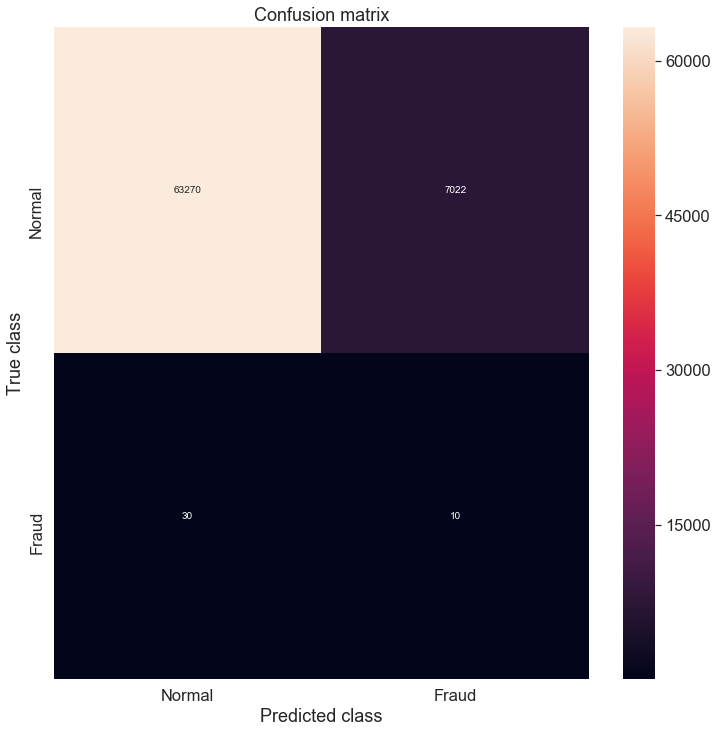

In [42]:
threshold = error_df.reconstruction_error.nlargest(int(0.1*len(error_df))).values[-1]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()